Code to generate networks with varying Trophic Incoherence and solve a network of Kuramoto oscilaltors. Data plots after the main cell. 

In [1]:
using LightGraphs, GraphIO, GraphPlot, NetworkDynamics, OrdinaryDiffEq, Plots, LightGraphs, Printf


#f=open("net_celegans_neural.dat")




In [2]:
using LinearAlgebra, IterativeSolvers, Statistics
#Function which calculates Trophic Level

function get_levels(A)
    
    A= convert(Array{Float64}, A)
    
    w_in = vec(sum(A, dims=1))
   
    w_out= vec(sum(A, dims=2))
    
   
    
    u = w_in + w_out 
    
    v= w_in - w_out 
   
    Lambda=  diagm(u)-  A - transpose(A)
    
   
    Lambda[1,1]= 0 
    
    #h= bicgstabl(Lambda, v, 10)
    h=  lsmr(Lambda, v)   
       
    h= h .- minimum(h)
    
    return h
end

get_levels (generic function with 1 method)

In [3]:
#Function to calculate Trophic Incohrence 


function calc_troph_incoh(A,h)
    
    F=0

    for (x,y,v) in zip(findnz(A)...)
  
    
        F = F + v*(h[y] - h[x] -1 )^2
        
    end
    
    F= F/sum(A)
    
end
    
    
    
    
    

calc_troph_incoh (generic function with 1 method)

In [4]:
#Setting up Kuramoto Oscillors. See NetworkDynamics.jl for details 

using SparseArrays

function kuramoto_edge!(e, θ_s, θ_d, K, t)
    e[1] = K * sin(θ_s[1] - θ_d[1])
end

function kuramoto_vertex!(dθ, θ, edges, ω, t)
    dθ[1] = ω
    sum_coupling!(dθ, edges)
end

vertex! = ODEVertex(f! = kuramoto_vertex!, dim = 1, sym=[:θ])
edge!   = StaticEdge(f! = kuramoto_edge!, dim = 1, coupling = :directed)


StaticEdge{typeof(kuramoto_edge!)}(kuramoto_edge!, 1, :directed, [:e])

In [5]:
using LinearAlgebra, OrdinaryDiffEq, Random
using Arpack

#setting up network number and size of network N
number= 100

N=100
#Range of T control paramater can be linear or log 

#T_list= LinRange(0.025, 8, number)

T_list= 10 .^ (range(-2,stop=2,length=number))


#T_list= 1.2*ones(number)

B=0

F_list = zeros(0)
#Controls the number of edges 

L_targ = 10*N
#Data lists 

stop= 2*N^2

eig_list= zeros(0)

r_list= zeros(0)

phase_list = zeros(0)


#stop = 5

#w_in=1

for n in 1:number
    
    println(n)
    
    
    g = SimpleDiGraph(N)
    
    #Intial Graph to add edges to 

    for i in (1+B):N
        
        pick = rand(B+1:N)
        
        add_edge!(g, pick, i)
        
        
        end 
    A = (adjacency_matrix(g))
    
    L=sum(A)
    
    h = get_levels(A)
    
    
    edgelist= Int[]
    
    problist= zeros(0)
    
    edge_start= zeros(Int64,0)
    
    edge_end = zeros(Int64, 0)
    
    #Calculate Probablities of Adding edges 

    for i in 1:N
        
        for j in (B+1):N
            
            if A[i,j]!=1 && i!=j
                #Fix Array indexing here doesn't make sense. Need 2d array
                append!( edgelist, [i,j] )
                append!( edge_start, i )
                append!(edge_end, j )
                
                prob = exp(-((h[j]-h[i] -1)^2)/T_list[n]/2)
                
                
                
                append!( problist, prob )
            end
            
            
            
            end
        
            end 
    
    prob_sum = sum(problist)
    
    loop_size= size(problist, 1)
    
    
    
    #More Effieciemt sampling of probabilities of edges addition 

        
    count=0
    
    
    
    while (-L + L_targ)>0
        
        count = count + 1 
        
        prob_sum = sum(problist)
        
        random = prob_sum*(rand())
        
        
        z=0
        
        
        for k in 1:loop_size
            
            z= z + problist[k]
            
           
            if z>=random
               
                if A[edge_start[k],edge_end[k]]==0
                
                   A[edge_start[k],edge_end[k]]=1
                    
                   problist[k]=0 
                
                    L = L +1
                    
                    break
                       
                else 
                    
                    println("Missed")
                    println(A[(edgelist[k])])
                    break
                   
              
                end     
            
            end
                end
            
            if (count-stop)>=0
            
                
                
            
                break
        
            
            
                end
        
    end
        
    
    
    

#Taking data on network using inbuilt functions    
  
    
    
h = get_levels(A)
    
F= calc_troph_incoh(A,h)    
append!( F_list, F )  
    
#println(maximum(real(eigvals(Matrix(A)))))

    
append!( eig_list, maximum(real(eigvals(Matrix(A))))  )  

g= SimpleDiGraph((A))    
    
#Setting up dyanmics using NetworkDyanmics.jl   
    
nd! = network_dynamics(vertex!, edge!, g, parallel=true);
    
w_in = vec(sum(A, dims=1))    

#ω = collect(1:N)./N
#ω  .-= sum(ω)/N
    
ω =   0*randn(N)
   
#K  = 1.0
    
    
 edge_k = zeros(0)        

    for e in edges(g)
        append!(edge_k, 1/(  size(inneighbors(g,dst(e)))[1]))
            
        end
           
    

K= edge_k*(L_targ/N )*10  
    
    
p  = (ω, K); # p[1] vertex parameters, p[2] edge parameters    
    
#x0 = collect(1:N)./N
#x0 .-= sum(x0)./N
    
#x0 =   2*pi*rand(N) .- pi 
#x0 =   randn(N) 
    

    

    
    
#Setting intial conditions    
frac= floor(Int,0.2*N)    
sorted = (sortperm(h))    
    
#x0 = sign.(h .- frac)
    
    
x0= pi*ones(N)
   
    
for b in 1:frac
  
    x0[sorted[b]]= 0
    
    
    println(h[sorted[b]])
    end    
    
    
#Solving sysyem of Equations and getting data
    
tspan = (0., 1000.)
prob = ODEProblem(nd!, x0, tspan, p)
sol = solve(prob, Tsit5())

println(size(sol[size(sol)[2]]))


r=  abs(sum(exp.(sol[size(sol)[2]]*im )))/N  

#r= abs(sum(exp.(sol[1]*im )))/N 
    
append!( r_list, r )   
    
phase=  mean(sol[size(sol)[2]])   
append!( phase_list, phase) 
    
println(phase)    
end



println(F_list)


println(phase_list)

1
0.33435457109151123
0.36902764439860425
0.38660088123549663
0.4383835277105317
0.4433735199246409
0.4592095021452205
0.4766724358690517
0.49409659474769896
0.673295118801124
0.7092656713858783
0.8181350003496333
0.8371783845267231
0.8959993266405861
0.9066054289575056
1.2346262553652865
1.26958674852508
1.326743133600134
1.3444576951006177
1.3493527308492068
(100,)
1.4380421644769842e-9
2
0.3949690322618866
0.4606198624512632
0.49568201696833114
0.508585887532496
0.5436941509242934
0.5452414580834002
0.5576791337237832
0.5636987576388532
0.5836692803178567
0.6980577152930318
0.7408394805942509
0.7666935397887131
0.7915918582058783
0.8022586384979569
0.8269493404194079
0.8510442224672596
0.8741420564134132
1.1047010756647968
1.1821302706014791
(100,)
0.009485447492283033
3
0.998597906326812
1.9961998372826315
2.472121786862331
3.196623086245391
3.3171552704254577
3.360404381563164
3.374628324226909
3.4213345483893414
3.4834811473505543
3.7835052853885367
4.206218886376781
4.2195361819

(100,)
-1.3479483438206156e-10
15
0.014219360693498828
0.6813255283010524
0.8168913991252755
0.8370711355508442
0.8711629629506978
1.1265506845348203
1.3199340816586225
1.475209467323341
1.6035862015019964
1.6834363562999604
1.7227860840036298
1.7379794662850214
1.7477977870160495
1.8452692069448902
1.912974637384276
1.9228707287575793
1.9495582130315074
2.084752868195472
2.090574626143784
(100,)
-1.0860261879835284e-8
16
0.04593949051545376
0.49887568970689666
0.5597810168284956
0.5726850817864717
0.5920899799138721
0.6200386228563308
0.6349544753068235
0.6617237041620097
0.6676315790070444
0.6717595466410495
0.678018976113397
0.714291171654817
0.720752860612371
0.7764043373771934
0.7816195495524854
0.7973076603601487
0.8251228476347168
0.8315416047873293
1.0897558469280855
(100,)
8.783031162123335e-9
17
4.440892098500626e-16
0.046115746867440244
0.8219151631236232
1.0326261770517116
1.0992312342436805
1.3231930289520681
1.7521261659397802
1.966301774489003
2.0756303633956525
2.134599

(100,)
1.0534856212963333
29
0.9982839220633783
1.9951644433370808
2.991682578397517
2.994986575436031
3.723568182636612
3.732513750710422
3.740242758022859
3.771893954096596
3.8612162119214144
3.865272175486246
3.8859930327224954
3.8912888208335796
3.9106948018064718
3.9588391890191508
4.008449776859065
4.094388754604305
4.1347444406185385
4.2637958751368945
4.311653327834679
(100,)
1.0819907847476296e-11
30
0.20582184923469704
0.20621906467776707
0.2288390030184928
0.3055506420563052
0.31528965341293347
0.3750696984314952
0.4925625854336513
0.5109653719464728
0.5464047704419372
0.590213329688793
0.8381033258865085
0.8434368544140851
0.8982680340197973
0.9031674679824044
0.9337356851182004
1.014537287908052
1.022033539200344
1.1212179279940504
1.2318499182736917
(100,)
7.748544707934966e-9
31
0.12016247462610341
0.19709701062344553
0.3588883298077321
0.4102790424179412
0.43502806843291886
0.5449947824982062
0.5475486868199966
0.6104918550106155
0.6657631123964163
0.7353237309627412
0.

(100,)
8.129579593807809e-10
43
0.24327212735528736
0.26311250137513165
0.40065880112320507
0.40384648336619877
0.42449786480881047
0.723785908767661
0.7520051876262275
0.7750535593651082
0.8681028845035477
0.9200907289530618
0.9524038101229124
1.0729760295815403
1.0746043397359566
1.0778085589882171
1.090581768574171
1.1100851131288958
1.1151382133502783
1.1334143583054301
1.2035832328747584
(100,)
0.12750036607849882
44
0.0613370561457387
0.13190261966745798
0.3059091275803001
0.31017457794661474
0.43610699134953923
0.6335943034589446
0.6404081476687118
0.6404650647913004
0.6588995092495066
0.661538861654253
0.7253424929360621
0.787669098452848
0.8434018301067149
0.8755776380591512
0.9534474218353197
0.985052161643606
0.9928364750763892
1.0047989751074675
1.0398136719447302
(100,)
-4.759789830890576e-10
45
0.10528255932541897
0.1616581962707082
0.41321071637369955
0.45691417524224875
0.4671970939277854
0.4715939732046124
0.653794451087871
0.6978013038543707
0.7258170924774425
0.74234

(100,)
1.2764475511654716
57
0.021027536999391083
0.09165684615087044
0.09286228544485242
0.1199722103174965
0.16870584324046312
0.2106656607931402
0.2312656611715368
0.25052595366112074
0.27195219529367287
0.27308889968233185
0.30157432174983023
0.30953588371739404
0.32519915722141113
0.363136447547731
0.38704191373303454
0.44201358979798655
0.47892708762960157
0.49924031007778635
0.5021619732302324
(100,)
1.572655842634794
58
0.22358884374987986
0.29382388398588
0.37710639029619686
0.38112959827844806
0.384617808883418
0.4531691355104229
0.5233152357211462
0.5261707808829102
0.5606579564655448
0.574213579336752
0.5816680752548938
0.5916223738148052
0.6277284594596017
0.6422206351187496
0.6573810126349243
0.6932526445950286
0.7057886853786053
0.7149828055775354
0.7339990736143482
(100,)
1.8886368970373693
59
0.19062145379892126
0.31296323318680586
0.43252383464303545
0.4629807732640411
0.48807868474070626
0.5594518857340759
0.5823433306479272
0.5899884003694242
0.7077147940166212
0.72

(100,)
2.132542652676652
71
0.06725972097417521
0.12411147194037808
0.17302251975840122
0.21418306757346173
0.2676587781955383
0.28890642404028877
0.29348113984304836
0.2976523657630244
0.3129950022861055
0.34567210820317396
0.3660662849925374
0.396370461693676
0.4081642680868016
0.41317518353332666
0.4336619122545046
0.4463481149906915
0.4653916393911989
0.4929044782656777
0.49682741139300735
(100,)
2.1448696011476427
72
0.03581934337425807
0.07009031159045276
0.1460978836428536
0.15970875102908533
0.2576411013002986
0.3479963653089264
0.35236663870201956
0.3628337857557129
0.3694689081282908
0.3894800805875195
0.39125746447779874
0.39901132403887307
0.43127234044185403
0.4508973593193548
0.4520517904252662
0.45400620321126384
0.4583612585194935
0.47172860364816005
0.48570668631755864
(100,)
2.1353300914477864
73
0.12489007611046554
0.14225558210795597
0.16258193493306827
0.17571066283326542
0.18891418926094733
0.2157805892346859
0.22911842669061466
0.24811518555263862
0.2516179890973

(100,)
2.34784346085293
85
0.006766620444996874
0.09852628534986163
0.10471491406787947
0.12388058242852751
0.1626884788591349
0.16310884141443505
0.17210822216752747
0.17652412649973065
0.18225289915593262
0.20516672817614967
0.21304854516272892
0.2159360255660005
0.22970509484817353
0.23568347210164864
0.23646808612041365
0.24027056536286034
0.24960235094650862
0.25197488690638603
0.28026450036377637
(100,)
2.3089485748894494
86
0.048744220945576344
0.10531722429977863
0.10878111235637988
0.1165442490302443
0.13318944009872627
0.14531474133864758
0.15409473704268983
0.164886356650609
0.1816436833735122
0.19518273353647309
0.19934692358969025
0.20037859618428816
0.2171172548592068
0.2186616268563753
0.22944632427956646
0.27200663213107273
0.28042708404879896
0.2951467409307357
0.3013144065089084
(100,)
2.2712254533519602
87
0.07138904135168841
0.09159531058054429
0.10492182751455736
0.13892914919753874
0.20894546265592534
0.22211465264809682
0.24493076293127775
0.24670558265460174
0.2

(100,)
2.3285241764616496
99
0.10868024485079872
0.11101535122687217
0.2158023955305264
0.29639751990774765
0.34790084767611246
0.36414653501151717
0.3681379271561527
0.395332523452433
0.39682551196179183
0.4166668498137397
0.4203213300205755
0.4338725254218263
0.4450599800832644
0.45142044712048834
0.46118128574187345
0.46243245318882853
0.46667279605175616
0.4774803637083588
0.49124349611500806
(100,)
2.367119806573968
100
0.16244172773364057
0.1650497411050993
0.18075146676512355
0.1895460109516682
0.1909976120074153
0.20000996785811123
0.20028512064065498
0.20530357436148736
0.24614686731684032
0.27901236971721255
0.2891851533542353
0.30194196245549876
0.31091857854126714
0.3237866296607933
0.3317337692481219
0.33507779402563237
0.3369226187030848
0.34459533460581177
0.3479892391445105
(100,)
2.324062943039975
[0.04594085196382728, 0.04275976079540591, 0.03102858109081486, 0.038986241750109986, 0.05456755190036991, 0.05512667412542114, 0.05557160360053529, 0.07291533828508201, 0.05

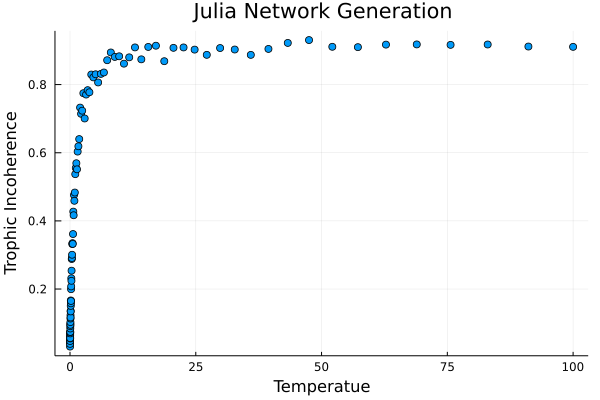

In [6]:
using Plots

plot(T_list,F_list, seriestype = :scatter, legend = false, xlabel= "Temperatue",

ylabel="Trophic Incoherence", title= "Julia Network Generation")

#savefig("Julia_generation_log_space.pdf")

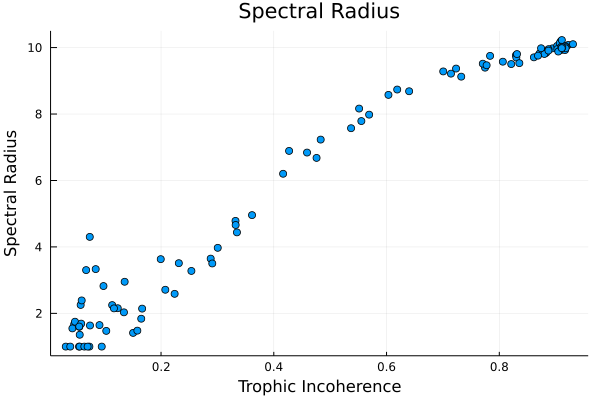

In [7]:
#println(eig_list)

plot(F_list, eig_list, seriestype = :scatter, legend = false, xlabel= "Trophic Incoherence",

ylabel="Spectral Radius", title= "Spectral Radius")


#savefig("Julia_generation_Spec_radius_logspace_2.pdf")

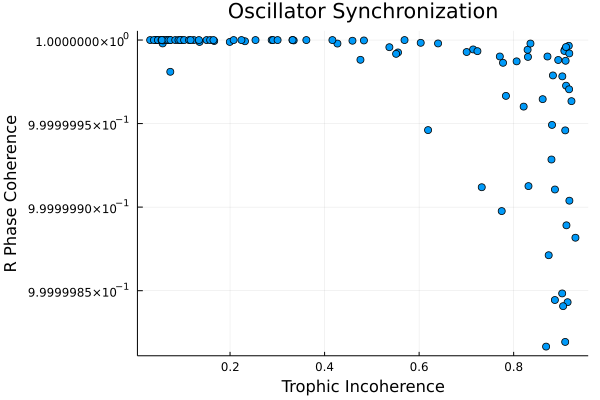

In [8]:
plot(F_list, r_list, seriestype = :scatter, legend = false, xlabel= "Trophic Incoherence",

ylabel="R Phase Coherence", title= "Oscillator Synchronization")


#savefig("Oscillator_Omega_equals_h_degree.pdf")

In [13]:
plot(F_list, cos.(phase_list), seriestype = :scatter, legend = false, xlabel= "Trophic Incoherence",

ylabel="Cosine of Average Phase", title= "Kuramoto Oscialltors")

#savefig("Mean_degree_generated_Kuramtoto_N_100_GRS3.pdf")

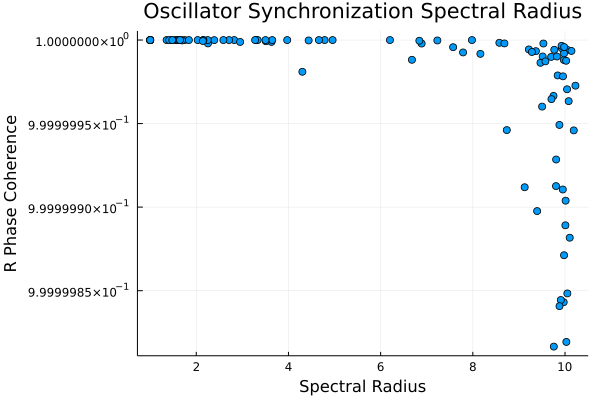

In [10]:
plot(eig_list, r_list, seriestype = :scatter, legend = false, xlabel= "Spectral Radius",

ylabel="R Phase Coherence", title= "Oscillator Synchronization Spectral Radius")